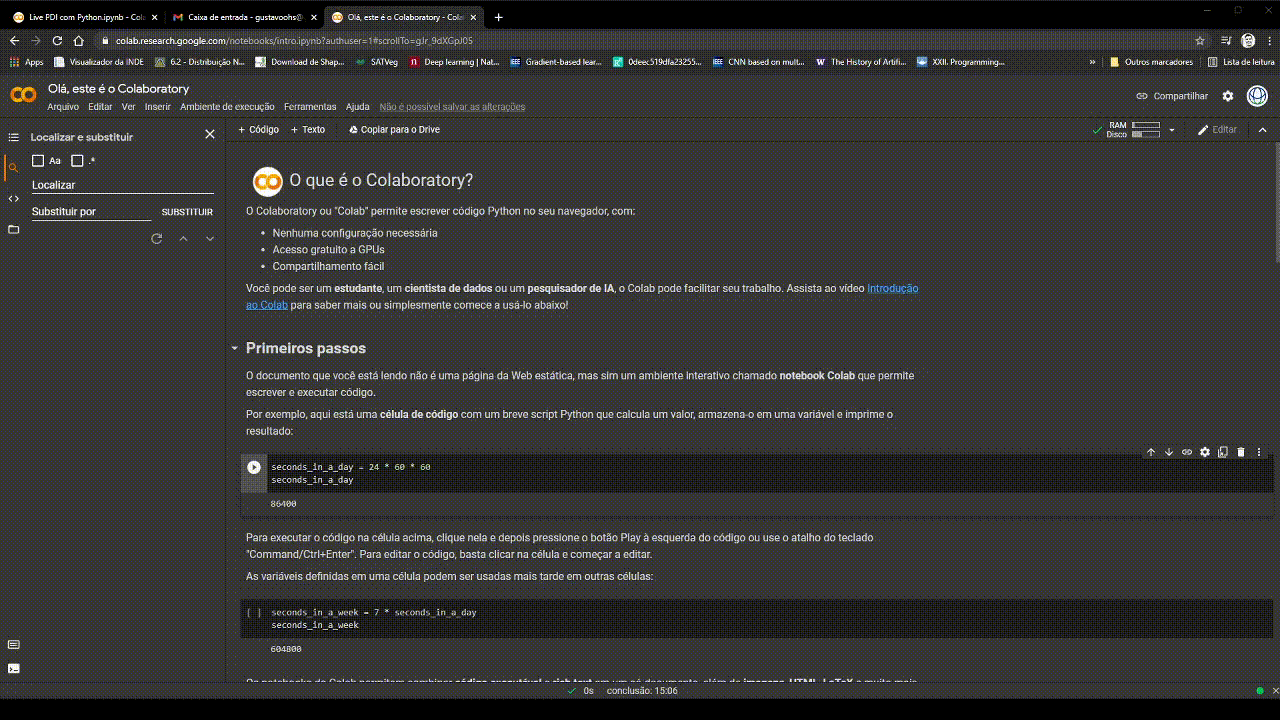

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2025-05-11 20:07:34--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   105MB/s    in 0.8s    

2025-05-11 20:07:35 (105 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=

In [2]:
!conda

usage: conda [-h] [-V] command ...

conda is a tool for managing and deploying applications, environments and packages.

Options:

positional arguments:
  command
    clean        Remove unused packages and caches.
    config       Modify configuration values in .condarc. This is modeled
                 after the git config command. Writes to the user .condarc
                 file (/root/.condarc) by default.
    create       Create a new conda environment from a list of specified
                 packages.
    help         Displays a list of available conda commands and their help
                 strings.
    info         Display information about current conda install.
    init         Initialize conda for shell interaction. [Experimental]
    install      Installs a list of packages into a specified conda
                 environment.
    list         List linked packages in a conda environment.
    package      Low-level conda package utility. (EXPERIMENTAL)
    remove       Rem

In [3]:
!pip install spectral

     |████████████████████████████████| 249 kB 6.8 MB/s 
     |████████████████████████████████| 15.7 MB 33.8 MB/s 


In [5]:
! conda install -c conda-forge Py6S -y

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

In [8]:
from spectral import imshow
import numpy as np
import tifffile as tif
from Py6S import *
import math

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
alt = 1.1

solar_z = 90 - 40.82290583

s = SixS()

In [11]:
s.atmos_profile = AtmosProfile.FromLatitudeAndDate(15, '2001-07-20')

s.aero_profile = AeroProfile.Continental

In [12]:
s.geometry = Geometry.User()
s.geometry.view_z = 0
s.geometry.solar_z = solar_z
s.geometry.monthy = 7
s.geometry.day = 20

s.altitudes.set_sensor_satellite_level()
s.altitudes.set_sensor_custom_altitude(alt)

In [13]:
def fun_ganho(banda):
  select = {'B1' : PredefinedWavelengths.LANDSAT_ETM_B1,
            'B2' : PredefinedWavelengths.LANDSAT_ETM_B2,
            'B3' : PredefinedWavelengths.LANDSAT_ETM_B3,
            'B4' : PredefinedWavelengths.LANDSAT_ETM_B4,
            'B5' : PredefinedWavelengths.LANDSAT_ETM_B5,
            'B7' : PredefinedWavelengths.LANDSAT_ETM_B7}

  return Wavelength(select[banda])

In [37]:
def reflectancia(banda, img):
  ESUN = {'B1' : 1970,
          'B2' : 1842,
          'B3' : 1547,
          'B4' : 1044,
          'B5' : 255.7,
          'B7' : 82.06}

  solar_z_corr = math.cos(solar_z)**2
  eq = ESUN[banda] * solar_z_corr / (math.pi*1.0161264**2)

  rad = img * eq
  s.wavelength = fun_ganho(banda)
  s.run()

  lp = s.outputs.atmospheric_intrinsic_radiance

  espalhamento = s.outputs.trans['total_scattering'].upward
  absorcao = s.outputs.trans['global_gas'].upward

  tau = espalhamento * absorcao

  edir = s.outputs.direct_solar_irradiance

  ediff = s.outputs.diffuse_solar_irradiance

  #ref = math.pi * (rad - lp) / tau * (edir + ediff)
  ref = ((rad - lp) * math.pi) / (tau*(edir+ediff))
  return ref

In [15]:
l7 = tif.imread('/content/drive/MyDrive/PDI com Python/correção atmosferica/Dados Landsat 7.zip/L71221071_07120010720_DN.tif')

In [16]:
l7.shape

(6, 1233, 1520)

In [17]:
band =['B1','B2','B3','B4','B5','B7']

In [18]:
f = np.zeros_like(l7)

In [39]:
for i in range(l7.shape[2]):
  # Ensure that 'i' stays within the valid range of the 'band' list (0 to 5)
  if i < len(band):
    f[i,:,:] = reflectancia(band[i], l7[i,:,:])
  else:
    # Handle the case where 'i' exceeds the 'band' list range
    print(f"Warning: Skipping band index {i} as it is out of range for the 'band' list.")
    # or raise an exception if desired
    # raise IndexError(f"Band index {i} is out of range for the 'band' list.")

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [np.float64(12.0), np.float64(255.0)]
    G: [np.float64(12.0), np.float64(255.0)]
    B: [np.float64(12.0), np.float64(255.0)]

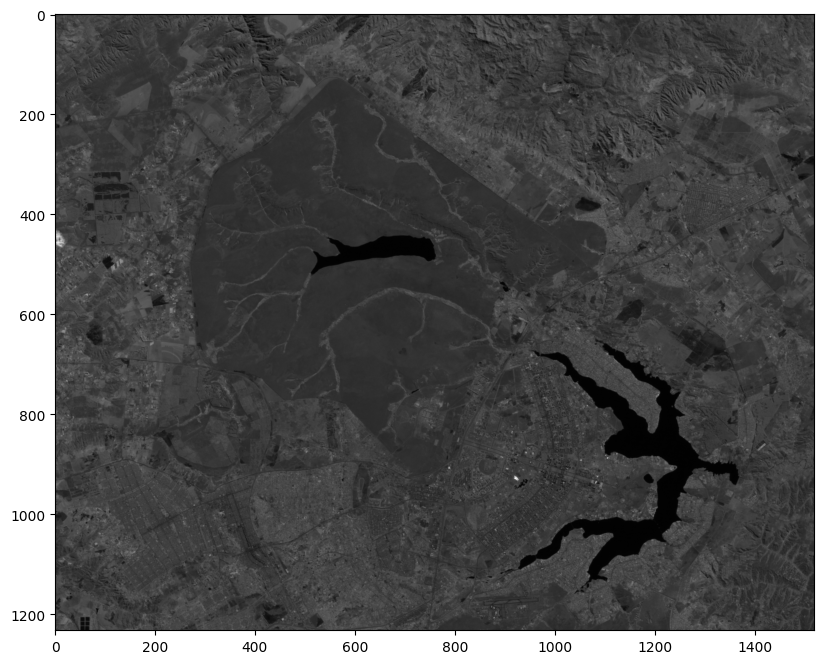

In [33]:
imshow(l7[3,:,:], figsize=(12,8))

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [np.float64(2.0), np.float64(104.0)]
    G: [np.float64(2.0), np.float64(104.0)]
    B: [np.float64(2.0), np.float64(104.0)]

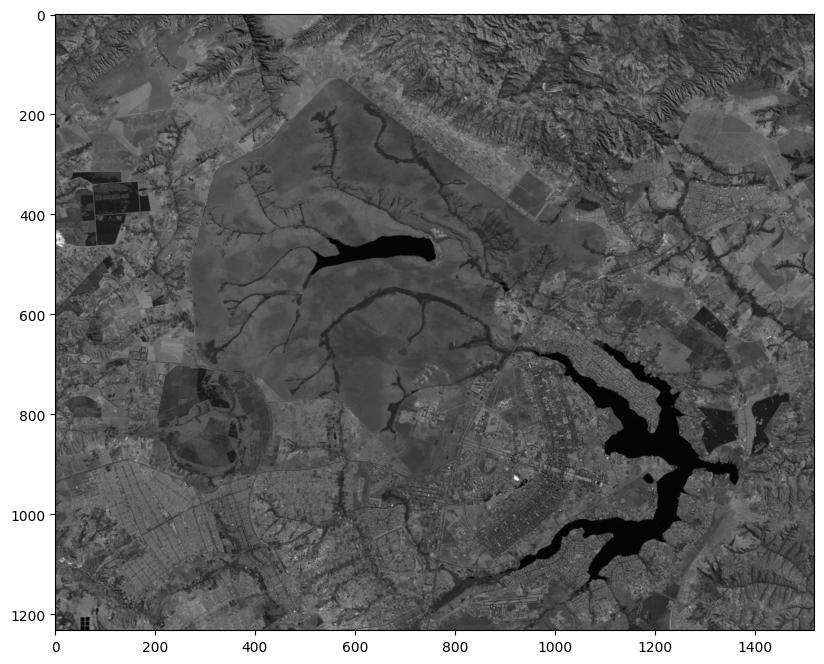

In [50]:
imshow(f[4,:,:], figsize=(12,8))